# Severity classification (binary + SMOTE)
The goal of this notebook is to infer the serverity of the injury of a user ('grav') based on the information available regarding the road accident.

In [6]:
from src.data_management import *
from src.plotting import *
import time
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE
import random
import numpy as np

### Model selection

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier


classifiers = [
    # DecisionTreeClassifier(), 
    RandomForestClassifier(n_jobs=-1), # OK
    # BaggingClassifier(n_jobs=-1), 
    LogisticRegression(n_jobs=-1), # SUPER OK
    # SVC(gamma='auto', C=1, cache_size=1900), # LONG (30k : 4min, 10k : 30s, 5k : 4s)
    GaussianNB(), # SUPER OK
    # SGDClassifier(n_jobs=-1),
    KNeighborsClassifier(n_jobs=-1), # SUPER OK
    #GradientBoostingClassifier(),
    MLPClassifier(), # OK
    #AdaBoostClassifier()
]

### Data loading
Data is loaded from the files and joined. Each feature is then processed to ensure that it is in the correct format for the model and then some features are dropped (according to the feature selection process).

In [8]:
nb_pca = 5

data_without_grav, grav, _ = workable_data(nb_pca)

# Binarizing grav
grav = grav.apply(lambda x: 0 if x in [1, 4] else 1)

# Oversampling
sm = SMOTE(k_neighbors=5, sampling_strategy=0.75)
data_without_grav_sm, grav_sm = sm.fit_resample(data_without_grav, grav)

# Shuffle data
indices = np.arange(len(data_without_grav_sm))
random.shuffle(indices)
data_without_grav_sm = data_without_grav_sm.iloc[indices]
grav_sm = grav_sm.iloc[indices]

indices = np.arange(len(data_without_grav))
random.shuffle(indices)
data_without_grav = data_without_grav.iloc[indices]
grav = grav.iloc[indices]

nb_lines = 10000
data_without_grav = data_without_grav[:nb_lines]
grav = grav[:nb_lines]
data_without_grav_sm = data_without_grav_sm[:nb_lines]
grav_sm = grav_sm[:nb_lines]

`data_without_grav` contains the 26 selected features, `grav` is the target variable and `data_PCA` contains the 5 principal components of the data.

### Model training

Data is split into training and testing sets using the `cross_validate` function from `sklearn.model_selection`. This function uses the `StratifiedKFold` method to ensure that the distribution of the target variable is the same in each training and testing set as in the original dataset.

A model of each type selected is trained following on such a fold. The model is then evaluated on the testing set using the following metrics:
- Accuracy
- Precision macro
- Recall macro
- F1 score macro

We chose to use the macro version of the metrics because the dataset is imbalanced and we want to ensure that the model is able to predict all classes correctly. The accuracy is also computed because it is a good indicator of the model's overall performance without taking into account the class distribution.

Fit the model with cross-validation on the features of the dataset with "grav" binaryzed

RandomForestClassifier done.
LogisticRegression done.
GaussianNB done.
KNeighborsClassifier done.
MLPClassifier done.


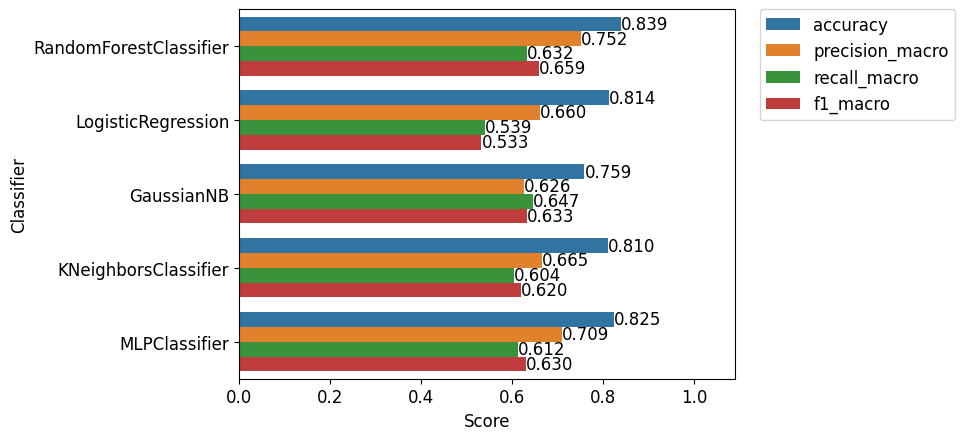

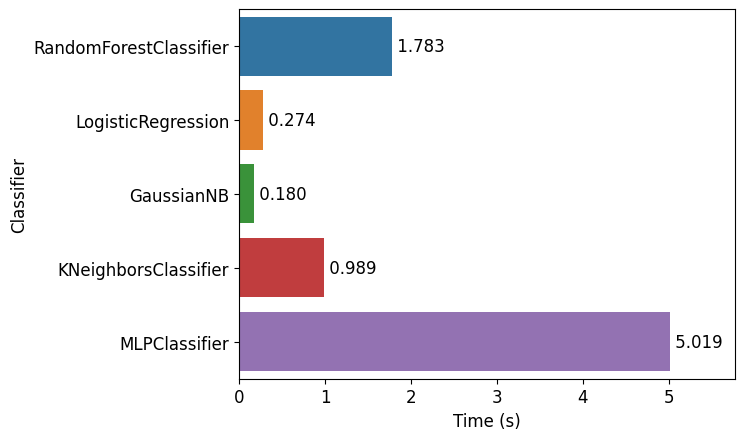

In [9]:
print('Fit the model with cross-validation on the features of the dataset with "grav" binaryzed\n')

metrics_computed = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
metrics_df = pd.DataFrame(columns=['clf', 'metric', 'score'])
time_df = pd.DataFrame(columns=['clf', 'time'])

for clf in classifiers:
    t = time.perf_counter()
    scores = cross_validate(clf, data_without_grav, grav, cv=5, scoring=metrics_computed, return_train_score=True, n_jobs=-1)
    time_df = time_df.append({'clf': clf.__class__.__name__, 'time': time.perf_counter() - t}, ignore_index=True)
    for metric in metrics_computed:
        metrics_df = metrics_df.append({'clf': clf.__class__.__name__, 'metric': metric, 'score': scores['test_'+metric].mean()}, ignore_index=True)
    print(clf.__class__.__name__ + ' done.')

plot_metrics(metrics_df)
plot_time(time_df)

Fit the model with cross-validation on the features of the dataset with "grav" binaryzed and minority oversampled

RandomForestClassifier done.
LogisticRegression done.
GaussianNB done.
KNeighborsClassifier done.
MLPClassifier done.


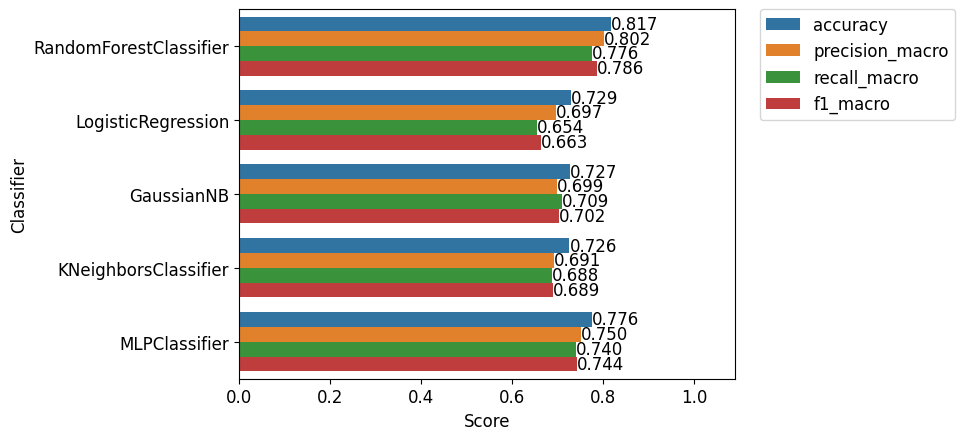

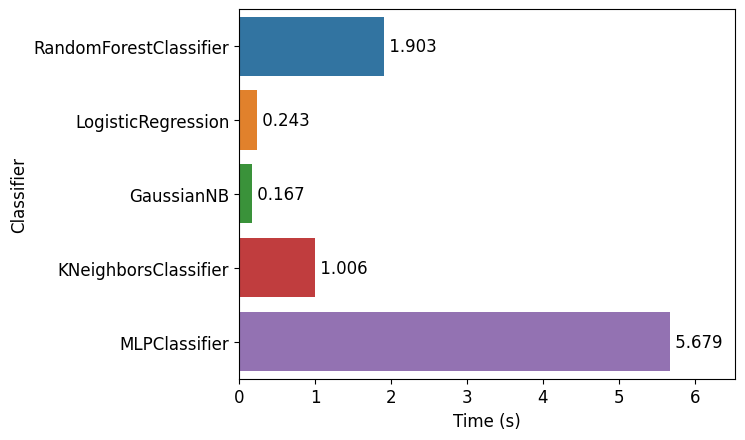

In [10]:
print('Fit the model with cross-validation on the features of the dataset with "grav" binaryzed and minority oversampled\n')

metrics_computed = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
metrics_df = pd.DataFrame(columns=['clf', 'metric', 'score'])
time_df = pd.DataFrame(columns=['clf', 'time'])

for clf in classifiers:
    t = time.perf_counter()
    scores = cross_validate(clf, data_without_grav_sm, grav_sm, cv=5, scoring=metrics_computed, return_train_score=True, n_jobs=-1)
    time_df = time_df.append({'clf': clf.__class__.__name__, 'time': time.perf_counter() - t}, ignore_index=True)
    for metric in metrics_computed:
        metrics_df = metrics_df.append({'clf': clf.__class__.__name__, 'metric': metric, 'score': scores['test_'+metric].mean()}, ignore_index=True)
    print(clf.__class__.__name__ + ' done.')

plot_metrics(metrics_df)
plot_time(time_df)